# Primer to HDF5 and h5py

Adapted by **Joshua Agar** based on notes by **Suhas Somnath**

* We collect a variety of file types HTML files, scientific journal articles in PDF files, tabular data in XLSX spreadsheets and so on

* Scientific instruments generate data in a variety of, typically proprietary, file formats. 
    * This impedes sharing of data, codes, and analysis packages.

## Solution
* Use Hierarchical Data Format (HDF5) files -- The most popular scientific data format.

* HDF5 mimics the familiar folders and files paradigm exposed to users by all operating systems.

* h5py is the official software package for reading and writing to HDF5 files in python. 

# HDF5 files can contain:

* ``Datasets`` - similar to spreadsheets and text files with tabular data.

* ``Groups`` - similar to folders in a regular file system

* ``Attributes`` - small metadata that provide additional information about the Group or Dataset they are attached to.

* other advanced features such as hard links, soft links, object and region references, etc.

## Motivation

### Proprietary file formats

Typically, each commercial instruments generates data files formatted in proprietary file formats by the instrument manufacturer. The proprietary nature of these file formats and the obfuscated data model within the files impede scientific progress in the following ways:

1. By making it challenging for researchers to extract data from these files

2. Impeding the correlation of data acquired from different instruments.

3. Inability to store results back into the same file

4. Inflexibility to accommodate few kilobytes to several gigabytes of data

5. Requiring different versions of analysis routines for each data format

6. In some cases, requiring proprietary software provided with the instrument to access the data

## Future concerns

1. Several fields are moving towards the open science paradigm which will require journals and researchers to support
   journal papers with data and analysis software

2. US Federal agencies that support scientific research mandate that the data be stored in a manner that is open, standardized and curation-ready in order to meet both the guidelines for data sharing and satisfy the implementation of digital data management as outlined by the United States Department of Energy.

## Other problems

1. The vast majority of scientific software packages (e.g. X-array) aim to focus at information already available in
   memory. In other words they do not solve the problem of storing data in a self-describing manner and reading +
   processing this data.
2. There are a few file formatting packages and approaches (Nexus, NetCDF). However, they are typically narrow in scope and only solve the data formatting for specific communities
3. Commercial image analysis software are often woefully limited in their capabilities and only work on simple 1, 2, and in some cases- 3D datasets. There are barely any software for handling arbitrarily large multi-dimensional datasets.
4. In many cases, especially electron and ion based microscopy, the very act of probing the sample damages the sample. 
    * To minimize damage to the sample, researchers only sample data from a few random positions in the 2D grid and use advanced algorithms to reconstruct the missing data. We have not come across any robust solutions for storing such **Compressed sensing / sparse sampling** data. More in the **Advanced Topics**.

# Importing Packages

In [1]:
from __future__ import print_function, division, unicode_literals
import os
import numpy as np
import h5py

* ``os`` - to manipulate and remove files
* ``numpy`` - for basic numerical work
* ``h5py`` - the package that will be the focus of this primer

# Creating a File
* Creating a HDF5 files using h5py is just like making a text file

In [4]:
# names the file
h5_path = 'hdf5_primer.h5'

# makes the file
h5_file = h5py.File('hdf5_primer.h5')

# prints the results
print(h5_file)

<HDF5 file "hdf5_primer.h5" (mode r+)>


* a file in the path specified by h5_path has been created and is now open for modification

# Groups

* We can use the `create_group()` function on an existing object such as the open file handle
* Groups are like **folders**

In [5]:
# Creates the group
h5_group_1 = h5_file.create_group('Group_1')

# prints the output
print(h5_group_1)

<HDF5 group "/Group_1" (0 members)>


# Groups within Groups
* Groups can contain groups within them just like folders

* We need to call the ``create_group()`` function on the h5_group_1 object and not the h5_file object. 
    * Calling the ``create_group()`` h5_file object result in groups created under the file at the same level as ``Group_1`` instead of inside ``Group_1``.

In [6]:
# making groups in groups
h5_group_1_1 = h5_group_1.create_group('Group_1_1')
h5_group_1_2 = h5_group_1.create_group('Group_1_2')

print(h5_group_1_1, h5_group_1_2)

<HDF5 group "/Group_1/Group_1_1" (0 members)> <HDF5 group "/Group_1/Group_1_2" (0 members)>


# .parent

* The hierarchical nature of HDF5 allows us to access datasets and groups using relationships or paths.

In [7]:
print('Parent of "Group_1" is {}'.format(h5_group_1.parent))
print('Parent of "Group_1_1" is {}'.format(h5_group_1_1.parent))

Parent of "Group_1" is <HDF5 group "/" (1 members)>
Parent of "Group_1_1" is <HDF5 group "/Group_1" (2 members)>


* You can also do logical operations on parents

In [8]:
print(h5_group_1_1.parent == h5_group_1)

True


# Accessing H5 objects

* HDF5 objects either through ``relative paths``, or ``absolute paths``. 
* Here are a few ways one could get to the group ``Group_1_2``:

In [9]:
print(h5_file['/Group_1/Group_1_2'])
print(h5_group_1['Group_1_2'])
print(h5_group_1_1.parent['Group_1_2'])

<HDF5 group "/Group_1/Group_1_2" (0 members)>
<HDF5 group "/Group_1/Group_1_2" (0 members)>
<HDF5 group "/Group_1/Group_1_2" (0 members)>


# .items()

* h5py group objects contain a dictionary of key-value pairs where they key is the name of the object and the value is a reference to the object itself

In [10]:
# loops through the key_value pairs in group_1
for key, value in h5_group_1.items():
    if key == 'Group_1_2':
        print('Found the desired object: {}'.format(value))

Found the desired object: <HDF5 group "/Group_1/Group_1_2" (0 members)>


# Creating Datasets

* We can create a dataset within ``Group_1``
* ``create_dataset()``. Unlike create_group() which just takes the path of the desired group as an input.

In our experience, there are three modes of creating datasets that are highly relevant for scientific applications:

* dataset with data at time of creation - where the data is already available at the time of creating the dataset
* empty dataset - when one knows the size of data but the entire data is not available
* resizable dataset - when one does not even know how large the data can be. *This case is rare*

## Creating Dataset with available data:
* We want to store a simple greyscale (floating point values) image with 256 x 256 pixels. 
* The precision with which the data is stored can significantly affect the size of the dataset and the file. 
* It is good practice to specify the ``dtype`` keyword argument during creation.

In [11]:
h5_simple_dataset = h5_group_1.create_dataset('Simple_Dataset', # names the dataset
                                              data=np.random.rand(256, 256), # builds a random dataset
                                              dtype=np.float32) # specifies the datatype

print(h5_simple_dataset)

<HDF5 dataset "Simple_Dataset": shape (256, 256), type "<f4">


# Accessing the Dataset

* We can access data contained in the dataset just like accessing a numpy array. For example, if we want the value at row ``29`` and column ``167``

In [12]:
 print(h5_simple_dataset[29, 167])

0.10335293


## Creating (potentially large) empty datasets

* We may know how much space to allocate for the final dataset but we may not have all the data at once. 
* Alternatively, the dataset is so large that we cannot fit the entire data in the computer memory before writing to the HDF5 file. 
* Or we have to read N files, each containing a small portion of the data and then write the contents into each slot in the HDF5 dataset.

### For example, assume that we have 128 files each having 1D spectra (amplitude + phase or complex value) of length 1024.

Here is how one may create the HDF5 dataset to hold the data:

In [13]:
h5_empty_dataset = h5_group_1.create_dataset('Empty_Dataset', # names the dataset
                                                 shape=(128, 1024), # sets the shape
                                                 dtype=np.complex64) # sets the datatype

* if we read the empty dataset there is nothing to read

In [14]:
print(h5_empty_dataset[5, 102])

0j


### populating with data

* One could populate each chunk of the dataset just like filling in a numpy array.

In [15]:
h5_empty_dataset[0] = np.random.rand(1024) + 1j * np.random.rand(1024)

### .flush()
* It is a good idea to make sure the data is actually commited to the file
* There is a chance that the data is still in the buffer and not yet in the file

In [16]:
h5_file.flush()

#### Views the dataset

In [17]:
print(h5_empty_dataset[0].shape)
print(h5_empty_dataset[0])

(1024,)
[0.7066999 +0.9996487j  0.00445038+0.56907266j 0.01727319+0.2876504j  ...
 0.85745686+0.9742367j  0.4574617 +0.93283147j 0.7311887 +0.3446422j ]


# Creating resizeable datasets

* Relevant to those situations where we only know how large each unit of data would be but we don’t know the number of units
* This is important when collecting data from an instrument. 

For example, if we were acquiring spectra: 
* length 128 on a 1D grid of 256 locations, we may have created an empty 2D dataset of shape (265, 128). 

**What if The data was being collected ordinarily over the first 13 positions but a change in parameters resulted in spectra of length 175 instead?**

* The data from the 14th position cannot be stored in the empty array due to a size mismatch. 

    * We would need to create another empty 256 x 175 dataset to hold the data and  whole lot of wasted space.

**In such cases, it is easier just to create datasets that can expand one pixel at a time.** 

For this specific example, one may want to create a 2D dataset of shape (1, 128) that could grow up to a maxshape of (256, 128) as shown below:

In [18]:
h5_expandable_dset = h5_group_1.create_dataset('Expandable_Dataset', # names the dataset
                                               shape=(1, 128), # set the shape
                                               maxshape=(256, 128), # set the max shape size
                                               dtype=np.float32) # sets the datatype
print(h5_expandable_dset)

<HDF5 dataset "Expandable_Dataset": shape (1, 128), type "<f4">


Space has been allocated for the first pixel, so the data could be written in as:

In [19]:
h5_expandable_dset[0] = np.random.rand(128)

For the next pixel, we would need to expand the dataset before filling it in:

In [20]:
h5_expandable_dset.resize(h5_expandable_dset.shape[0] + 1, axis=0) # grows the dataset
print(h5_expandable_dset)

<HDF5 dataset "Expandable_Dataset": shape (2, 128), type "<f4">


* the dataset has increased in size in the first dimension allowing the second pixel to be stored. The second pixel’s data would be stored in the same way as in the first pixel and the cycle of expand and populate-with-data would continue.

* There is a non-trivial storage overhead associated with each resize operation. 
* A file containing this resizeable dataset that has been resized 255 times will certainly be larger than a similar file where the dataset space was pre-allocated and never expanded. 
* Therefore this mode of creating datasets should used sparingly.

# Attributes

* are metadata that can convey information that cannot be efficiently conveyed using Group or Dataset objects.

* are almost exactly like python dictionaries in that they have a key-value pairs.

* can be stored in either Group or Dataset objects.

* are not appropriate for storing large amounts of information. Consider datasets instead

* are best suited for things like experimental parameter such as beam intensity, scan rate, scan width, etc.

## Writing Attributes
* These are saved like python dictionaries

In [21]:
h5_simple_dataset.attrs['single_num'] = 36.23   # Stores a single number as an attribute
h5_simple_dataset.attrs.update({'list_of_nums': [1, 6.534, -65],
                               'single_string': 'hello'}) # stores a few numbers as an attribute

## Reading
We would read the attributes just like we would treat a dictionary in python:



In [22]:
for key, val in h5_simple_dataset.attrs.items():
    print('{} : {}'.format(key, val))

list_of_nums : [  1.      6.534 -65.   ]
single_num : 36.23
single_string : hello


In [23]:
print('single_num: {}'.format(h5_simple_dataset.attrs['single_num'] == 36.23))
print('list_of_nums: {}'.format(np.all(h5_simple_dataset.attrs['list_of_nums'] == [1, 6.534, -65])))
print('single_string: {}'.format(h5_simple_dataset.attrs['single_string'] == 'hello'))

single_num: True
list_of_nums: True
single_string: True


# The USIDataset

Information in **USID** are stored in three main kinds of datasets:

1. ``Main`` datasets that contain the raw measurements recorded from
   the instrument as well as results from processing or analysis routines
   applied to the data

2. Mandatory ``Ancillary`` datasets that are necessary to explain the
   ``main`` data

3. ``Extra`` datasets store any other data that may be of value

In addition to datasets, the data schema is highly reliant on metadata that capture smaller pieces but critical pieces of information such as the ``quantity`` and ``units`` that describe every data point in the ``main`` dataset.

# ``Main`` Datasets


Regardless of origin, modality or complexity, imaging data (and most scientific data for that matter) have one
thing in common:

**The same measurement / operation is performed at each spatial position**

The **USID** schema is based on this one simple ground-truth.
The data always has some ``spatial dimensions`` (X, Y, Z) and some
``spectroscopic dimensions`` (time, frequency, intensity, wavelength,
temperature, cycle, voltage, etc.). 

**In USID, the spatial
dimensions are collapsed onto a single dimension and the spectroscopic
dimensions are flattened into the second dimension.** 

* All data is stored as **two dimensional arrays**. The data would be arranged in the same manner that reflects the sequence in which the individual data points were collected. Examples below will simplify this data-representation paradigm significantly.

In general, if a measurement of length ``P`` was recorded for each of ``N`` positions,
it would be structured as shown in the table below here the prefixes ``i`` correspond to
the positions and ``j`` for spectroscopic:

![](./images/table)

A notion of chronology is attached to both the position and spectroscopic axes.
* Data for the second location (second row in the above table) was acquired after the first location (first row). 
* The same applies to the spectroscopic axis as well.

* This is an important point to remember especially when information is recorded from multiple sources or channels (e.g. - data from different sensors) or if two or more numbers are **necessary** to give a particular observation / data point its correct meaning (e.g. - color images).

While the data could indeed be stored in the original N-dimensional form,
there are a few key **advantages to the 2D structuring**:

![](./images/2D_images.svg)

* The data is already of the **same structure expected by machine learning algorithms** and requires minimal
  to no pre-processing or post-processing. 
    * Briefly, the data is simply arranged in the standard form of ``instances x features``,  where ``instances`` makes up the locations and ``features`` which contains all the observables per entry.

* In certain cases, the data simply **cannot be represented in an N-dimensional form** since one of the dimensions
  has multiple sizes in different contexts.

![](./images/3D_map_of_spectra.svg)

* Researchers want to acquire ever larger datasets that
  take much longer to acquire. 
  * This has necessitated approaches such as **sparse sampling** or `compressed sensing <https://en.wikipedia.org/wiki/Compressed_sensing>`__ wherein measurements are acquired from a few randomly sampled positions and the data for the rest of the positions are inferred using complex algorithms. 
  * Storing such sparse sampled data in the N dimensional form would balloon the size of the stored data even though the majority of the data is actually empty. 
      * Two dimensional datasets would allow the random measurements to be written without any empty sections.

* When acquiring measurement data, users often adjust experimental parameters during the experiment that may affect the size of the data, especially the spectral sizes. 
* Thus, **changes in experimental parameters** would mean that the existing N dimensional set would have to be left partially (in most cases largely) empty and a new N dimensional dataset would have to be allocated with the first few positions left empty. 
* In the case of flattened datasets, the current dataset can be truncated at the point of the parameter change and a new dataset can be created to start from the current measurement. Thus, no space would be wasted.

# Example on Spectra Data

In [43]:
%matplotlib inline

## Import Packages

In [44]:
from __future__ import print_function, division, unicode_literals
import subprocess
import sys
import os
from warnings import warn
import h5py
import numpy as np
import matplotlib.pyplot as plt


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

## Download the dataset
We will be working on a **Force-Distance Curve** obtained from an Atomic Force Microscope (AFM) in this example.
As mentioned earlier, this dataset is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [45]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/AFM_Force_Curve.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
-------------
Lets open the file and look at its contents using
`pyUSID.hdf_utils.print_tree() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#print-tree>`_



In [46]:
h5_file = h5py.File(h5_path, mode='r')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


* This file contains a single `Measurement` which has a single `Channel <../usid_model.html#channels>`_.
* We can access the `Main Dataset <../usid_model.html#main-datasets>`_ where all the information is located in
multiple ways. 
    * Given that this file contains just a single ``Main Dataset`` we can conveniently use the `pyUSID.hdf_utils.get_all_main() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#get-all-main>`_ function.



In [47]:
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
print(h5_main)

<HDF5 dataset "Raw_Data": shape (1, 2045), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 1 
Spectroscopic Dimensions: 
	Z - size: 2045
Data Type:
	float32


Here, ``h5_main`` is a `USIDataset <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html>`_, which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``Raw_Data`` dataset but also its links to the
`Ancillary Datasets <../usid_model.html#ancillary-datasets>`_ that make it a ``Main Dataset``.

### Understanding Dimensionality

* What is more is that the above print statement shows that this ``Main Dataset`` has one ``Position Dimension`` - ``X``
* which was varied over a single value and a single ``Spectroscopic Dimension`` - ``Z`` which was varied several times.
* Therefore, this dataset is really just a simple 1D dataset where the sole dimension is ``Z``.

The original shape of this dataset would be ``(2045,)``. In USID, this shape needs to (explicitly) include a position
axis to state that the measurement was acquired over a single position / location. Therefore, the shape of this data
in USID would be ``(1, 2045)``

## Visualize the Main Dataset

Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
`visualize() <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html#interactive-visualization>`_ function. 

In [80]:
usid.plot_utils.use_nice_plot_params()
h5_main.visualize()

Object `h5_main.visualize()` not found.


# Doing this manually

/Users/joshuaagar/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


NameError: name 'USID' is not defined

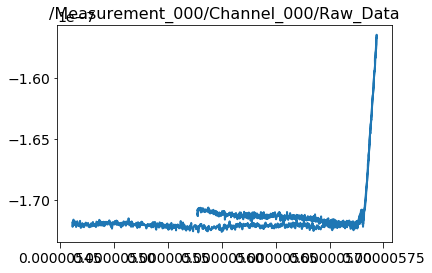

In [84]:
plt.plot(h5_main.h5_spec_vals.value[0],h5_main[0])
plt.title(h5_main.name)

## Ancillary Datasets

* ``Ancillary Datasets`` are required to complete the information for any dataset. 
    * provide information about the values against which measurements were acquire. 
    * Explain the original dimensionality (1 in this case) of the original dataset. 

Let's look at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets`` linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

## Ancillary Position Datasets

* Given that this force-distance curve was acquired at a single position, the ancillary position datasets become trivial

as seen below. Note that we access the ``Ancillary Datasets`` as properties of ``h5_main``:

In [85]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('containing:')
print(h5_main.h5_pos_inds[()])
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)
print('containing:')
print(h5_main.h5_pos_vals[()])

Position Indices:
-------------------------
<HDF5 dataset "Position_Indices": shape (1, 1), type "<u4">
containing:
[[0]]

Position Values:
-------------------------
<HDF5 dataset "Position_Values": shape (1, 1), type "<f4">
containing:
[[1.]]


* Note that these position datasets only contain a single value position axis. Regardless of the fact that the data was collected at a single location, the Position datasets should be two dimensional in shape (one element in each axis) according the USID rules.

    * Regardless of how uninformative the Position Datasets seem for this specific example, they are still necessary for the ``Raw_Data`` dataset to be a ``Main Dataset``.

### Attributes associated with the Position Indices Dataset

* Just looking at the shape and values of the Position ancillary datasets does not provide all the information.
    * Recall that the ancillary datasets need to have some mandatory attributes like ``labels`` and ``units`` that
describe the quantity and units for each of the dimensions:

In [86]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_pos_inds).items():
    print('{} : {}'.format(key, val))

X : <HDF5 region reference>
labels : ['X']
units : ['a. u.']


Ancillary Spectroscopic Datasets
--------------------------------
Unlike the Position ``Ancillary Datasets`` that are not very descriptive for this example, the Spectroscopic Datasets
are very important since these datasets explain how the independent variable, ``Z`` was varied.

Looking at the Spectroscopic HDF5 datasets
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [87]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 2045), type "<u4">

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 2045), type "<f4">


* The first index in the shape of both datasets indicates that there is a single Spectroscopic Dimension.
* The second index in the shape of the datasets indicates that this single dimension was varied over several values.

### Attributes within the Spectroscopic Indices Dataset

The attributes of Spectroscopic Datasets show mandatory information about the Spectroscopic dimensions such as
the quantity (``labels``) and ``units``:

In [88]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_spec_inds).items():
    print('{} : {}'.format(key, val))

Z : <HDF5 region reference>
labels : ['Z']
units : ['m']


## Visualize the contents of the Spectroscopic Datasets

* Observe the single curve that is associated with the single spectroscopic variable ``Z``. 
    * The contents of the ``Spectroscopic Indices`` dataset are just a linearly increasing set of numbers starting from ``0`` according to the definition of the Indices datasets which just count the nth value of independent variable that was varied.
* The ``Spectroscopic Values`` dataset clearly shows that this variable varies non-linearly and could not have been represented using trivial bookkeeping. **This ability to allow dimensions to vary in arbitrary manners is one of the biggest strengths of USID over other alternatives.**



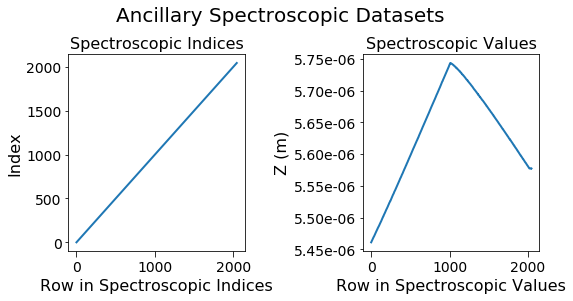

In [91]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for axis, data, title, y_lab in zip(axes.flat,
                                    [h5_main.h5_spec_inds[()].T, h5_main.h5_spec_vals[()].T],
                                    ['Spectroscopic Indices', 'Spectroscopic Values'],
                                    ['Index', h5_main.spec_dim_descriptors[0]]):
    axis.plot(data)
    axis.set_title(title)
    axis.set_xlabel('Row in ' + title)
    axis.set_ylabel(y_lab)

usid.plot_utils.use_scientific_ticks(axis, is_x=False)
fig.suptitle('Ancillary Spectroscopic Datasets', y=1.05)
fig.tight_layout()

Clean up
--------
Finally lets close the HDF5 file.



In [ ]:
h5_file.close()

* This case encompasses examples such as a **single** Raman spectrum, force-distance curve in atomic force microscopy, current-voltage spectroscopy, etc. In this case, the measurement is recorded
at a single location meaning that this dataset has a single *arbitrary* ``position dimension`` of size 1. 
* At this position, data is recorded as a function of a single variable (``spectroscopic dimension``) such as *wavelength* or *frequency*.
Thus, if the spectrum contained ``S`` data points, the **USID** representation of this data would be a ``1 x S`` matrix. The ``quantity`` represented in this data would be **Amplitude**.

# Example on Grayscale Images

* A single value (``quantity`` is *intensity*) in is recorded at each location in a two dimensional grid. Thus, there are are two
``position dimensions`` - *X*, *Y*. The value at each pixel was not really acquired as a function of any variable so the data has one *arbitrary* ``spectroscopic dimension``.
* If the image had ``P`` rows and ``Q`` columns, it would have to be flattened and represented as a ``P*Q x 1`` array. 
    * The second axis has size of 1 since we only record one value (intensity) at each location. 

# 2D Image

**This example illustrates how a 2D grayscale image would be represented in the Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**

### Import all necessary packages

The main packages necessary for this example are ``h5py`` and ``matplotlib`` in addition to ``pyUSID``:

In [92]:
from __future__ import print_function, division, unicode_literals
import subprocess
import sys
import os
from warnings import warn
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

Source image
-------------
For this example, we will be working with a simple grayscale image.

Download from GitHub
~~~~~~~~~~~~~~~~~~~~
As mentioned earlier, this image is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [93]:
image_path = 'temp.tif'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/simulated_STEM_Image.tif'
if os.path.exists(image_path):
    os.remove(image_path)
_ = wget.download(url, image_path, bar=None)

More about this image
~~~~~~~~~~~~~~~~~~~~~
Lets visualize this image and learn about its original shape:



Text(0.5, 1.0, 'Image of shape: (256, 256)')

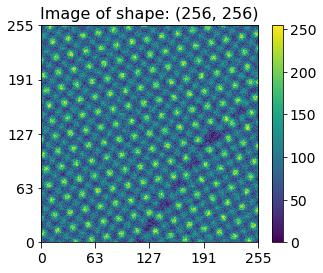

In [94]:
img_obj = Image.open(image_path)
# Convert to grayscale:
img_obj = img_obj.convert(mode="L")
orig_image = np.asarray(img_obj)

fig, axis = plt.subplots()
usid.plot_utils.plot_map(axis, orig_image, num_ticks=5)
axis.set_title('Image of shape: {}'.format(orig_image.shape))

h5USID File
-----------
Download from GitHub
~~~~~~~~~~~~~~~~~~~~~
Similarly the corresponding h5USID dataset is also available on the USID repository.
Here, we will simply download the file using ``wget``:



In [95]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/simulated_STEM_Image.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
~~~~~~~~~~~~~
Lets open the file and look at its contents using
`pyUSID.hdf_utils.print_tree() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#print-tree>`_



In [96]:
h5_file = h5py.File(h5_path, mode='r')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


Access the ``Main`` Dataset containing the image of interest
------------------------------------------------------------
* This file contains a single `Measurement` which has a single `Channel <../usid_model.html#channels>`_.
We can access the `Main Dataset <../usid_model.html#main-datasets>`_ where all the information is located in
multiple ways. 
* Given that this file contains just a single ``Main Dataset`` we can conveniently use the
`pyUSID.hdf_utils.get_all_main() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#get-all-main>`_ function.



In [97]:
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
print(h5_main)

<HDF5 dataset "Raw_Data": shape (65536, 1), type "|u1">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Intensity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 256 
	Y - size: 256 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	uint8


Here, ``h5_main`` is a `USIDataset <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html>`_, which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``Raw_Data`` dataset but also its links to the
`Ancillary Datasets <../usid_model.html#ancillary-datasets>`_ that make it a ``Main Dataset``.

## Understanding Dimensionality

* ``Main Dataset`` has two ``Position Dimensions`` -
``X`` and ``Y`` each of size ``256`` 
* A single ``Spectroscopic Dimension`` - ``None`` which was never varied at each of the locations in the dataset.

This dataset is really just a simple 2D dataset with both dimensions being position dimensions.
In other words, this dataset is just a simple 2D spatial / locations map.

The original shape of the source image was ``(256, 256)``. However, recall that USID requires all position dimensions
to be flattened along the first axis and all spectroscopic dimensions to be flattened along the second axis of the
``Main Dataset``. 
* This means that the image needs to be represented as a ``(256 * 256, 1)`` in USID.
* In USID, this shape needs to (explicitly) include a spectroscopic axis to state that a single data point was recorded at each location.

## Visualize the Main Dataset

Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in `visualize() <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html#interactive-visualization>`_ function. 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ba8fd9550>)

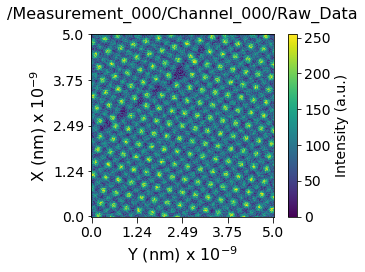

In [98]:
usid.plot_utils.use_nice_plot_params()
h5_main.visualize(num_ticks=5)

## Ancillary Datasets

 ``Ancillary Datasets`` are required to complete the information for any dataset. 
* These datasets need to provide information about the values against which measurements were acquired, in addition to explaining the original dimensionality (2 in this case) of the original dataset. 

Let's look at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets`` linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

### Ancillary Position Datasets

In [99]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)

Position Indices:
-------------------------
<HDF5 dataset "Position_Indices": shape (65536, 2), type "<u4">

Position Values:
-------------------------
<HDF5 dataset "Position_Values": shape (65536, 2), type "<f4">


* The shape of the Position Ancillary datasets is ``(N, P)`` where ``N`` is the number of Position dimensions and the ``P`` is the number of locations over which data was recorded. 
    * we have two position dimensions. Therefore ``N`` is ``2``. ``P`` matches with the first axis of the shape of ``h5_main`` which is ``65536``. 
    * Generally, there is no need to remember these rules or construct these ancillary datasets manually since pyUSID has several functions that automatically simplify this process.

### Visualize the contents of the Position Ancillary Datasets

Notice below that there are two sets of lines, one for each dimension. 
* The blue lines on the left-hand column appear solid simply because this dimension (``X`` or columns) varies much faster than the other dimension (``Y`` or rows). 

The first few rows of the dataset are visualized on the right-hand column.

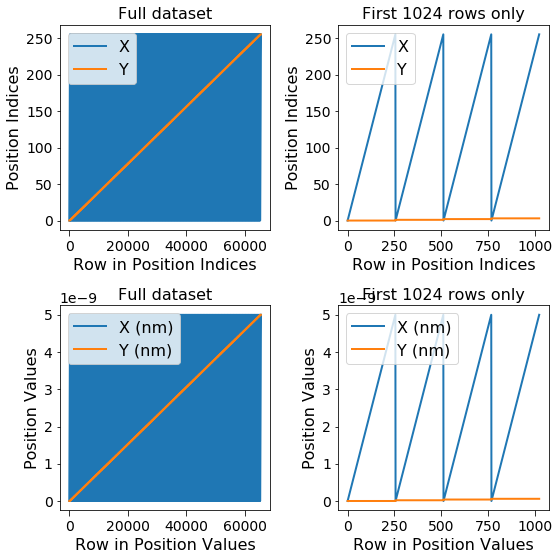

In [100]:
fig, all_axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

for axes, h5_pos_dset, dset_name in zip(all_axes,
                                        [h5_main.h5_pos_inds, h5_main.h5_pos_vals],
                                        ['Position Indices', 'Position Values']):
    axes[0].plot(h5_pos_dset[()])
    axes[0].set_title('Full dataset')
    axes[1].set_title('First 1024 rows only')
    axes[1].plot(h5_pos_dset[:1024])
    for axis in axes.flat:
        axis.set_xlabel('Row in ' + dset_name)
        axis.set_ylabel(dset_name)
        axis.legend(h5_main.pos_dim_labels)

for axis in all_axes[1]:
    axis.legend(h5_main.pos_dim_descriptors)

fig.tight_layout()

#### Making sense of the visualization

Given that the columns vary faster than the rows means that the contents of each row of the image have been stored end-to-end in the ``Main Dataset`` as opposed to on top of each other as in the original 2D image.

#### Attributes associated with the Position Indices Dataset

Just looking at the shape and values of the Position ancillary datasets does not provide all the information.
Recall that the ancillary datasets need to have some mandatory attributes like ``labels`` and ``units`` that
describe the quantity and units for each of the dimensions:

In [101]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_pos_inds).items():
    print('{} : {}'.format(key, val))

X : <HDF5 region reference>
Y : <HDF5 region reference>
labels : ['X' 'Y']
units : ['nm' 'nm']


Ancillary Spectroscopic Datasets
--------------------------------
Given that this is a 2D image where data was not acquired as a function of some independent parameter at each
location, the spectroscopic datasets will contain bare minimum information



In [102]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('containing:')
print(h5_main.h5_spec_inds[()])
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)
print('containing:')
print(h5_main.h5_spec_vals[()])

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 1), type "<u4">
containing:
[[0]]

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 1), type "<f4">
containing:
[[1.]]


Regardless of how uninformative the spectroscopic Datasets seem for this specific example, they are still necessary
for the ``Raw_Data`` dataset to be a ``Main Dataset``.

Attributes within the Spectroscopic Indices Dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Again, the attributes of Spectroscopic Datasets show mandatory information about the Spectroscopic dimensions such as
the quantity (``labels``) and ``units``:

In [103]:
for key, val in usid.hdf_utils.get_attributes(h5_main.h5_spec_inds).items():
    print('{} : {}'.format(key, val))

None : <HDF5 region reference>
labels : ['None']
units : ['a.u.']


Attempting to visualize the first few rows of the image manually
----------------------------------------------------------------



In [104]:
print(h5_main.pos_dim_labels)
print(h5_main.pos_dim_sizes)

['X', 'Y']
[256, 256]


In [105]:
rows_to_read = 50
num_cols = h5_main.pos_dim_sizes[1]
first_few_rows_1D = h5_main[: rows_to_read * num_cols, :]
print(first_few_rows_1D.shape)

(12800, 1)


In [106]:
first_few_rows_2D = np.reshape(first_few_rows_1D, (rows_to_read, num_cols))
print(first_few_rows_2D.shape)

(50, 256)


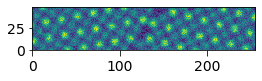

In [107]:
fig, axis = plt.subplots(figsize=(4, 1))
axis.imshow(first_few_rows_2D, origin='lower')

Clean up
--------
Finally lets close the HDF5 file.



In [108]:
h5_file.close()

#  Simultaneously acquired 2D images


**This example illustrates how a set of *simultaneously acquired* 2D grayscale images would be represented in the
Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**

This example is based on the popular Atomic Force Microscopy scan mode where multiple sensors *simultaneously* acquire a value at each position on a 2D grid, thereby resulting in a 2D image per sensor. 
* Specifically, the goal of this example is to demonstrate the sharing of ``Ancillary`` datasets among multiple ``Main`` datasets.

## Import all necessary packages

The main packages necessary for this example are ``h5py`` and ``matplotlib`` in addition to ``pyUSID``:

In [109]:
from __future__ import print_function, division, unicode_literals
import subprocess
import sys
import os
from warnings import warn
import h5py


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

Download the dataset
---------------------
As mentioned earlier, this image is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [110]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/SingFreqPFM_0003.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
-------------
Lets open the file and look at its contents using
`pyUSID.hdf_utils.print_tree() <../../pyUSID/auto_examples/beginner/plot_hdf_utils_read.html#print-tree>`_



In [111]:
h5_file = h5py.File(h5_path, mode='r')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Channel_002
    -----------
    ├ Raw_Data
  ├ Channel_003
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values


Notice that this file has multiple `Channels </../usid_model.html#channels>`_, each with a dataset named
``Raw_Data``. Are they all `Main </../usid_model.html#main-datasets>`_ datasets?
There are multiple ways to find out this. One approach is simply to ask pyUSID to list out all available ``Main``
datasets.

Visualize the contents in each of these channels
------------------------------------------------



In [112]:
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    print(main_dset)
    print('---------------------------------------------------------------\n')

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	HeightRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb - size: 1
Data Type:
	float32
---------------------------------------------------------------

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_001/Raw_Data 
Data contains: 
	AmplitudeRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb - size: 1
Data Type:
	float32
---------------------------------------------------------------

<HDF5 dataset "Raw_Data": shape (16384, 1), type "<f4">
located at: 
	/Measurement_000/Channel_002/Raw_Data 
Data contains: 
	DeflectionRetrace (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	arb

From the print statements above, it is clear that each of these ``Raw_Data`` datasets were indeed ``Main`` datasets.
How can these datasets be ``Main`` if they are not co-located with the corresponding sets of ``Ancillary`` datasets
within each ``Channel`` group?

## Sharing Ancillary Datasets

Since each of the ``Main`` datasets have the same position and spectroscopic dimensions, they share the same
set of ancillary datasets that are under ``Measurement_000`` group.
* This is common where information from multiple sensors are recorded **simultaneously** during the scan.

Recall from the USID that:

1. Multiple ``Main`` datasets can share the same ``Ancillary`` datasets
2. The ``Main`` datasets only need to have ``attributes`` named ``Position_Indices``, ``Position_Values``,
   ``Spectroscopic_Indices``, and ``Spectroscopic_Values``with the value set to the reference of the corresponding
   ``Ancillary`` datasets

We can investigate if this is indeed the case here. Lets get the references to ``Ancillary`` datasets linked to each
of the ``Main`` datasets:

In [113]:
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    print('Main Dataset: {}'.format(main_dset.name))
    print('Position Indices: {}'.format(main_dset.h5_pos_inds.name))
    print('Position Values: {}'.format(main_dset.h5_pos_vals.name))
    print('Spectroscopic Indices: {}'.format(main_dset.h5_spec_inds.name))
    print('Spectroscopic Values: {}'.format(main_dset.h5_spec_vals.name))
    print('---------------------------------------------------------------\n')

Main Dataset: /Measurement_000/Channel_000/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
---------------------------------------------------------------

Main Dataset: /Measurement_000/Channel_001/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
---------------------------------------------------------------

Main Dataset: /Measurement_000/Channel_002/Raw_Data
Position Indices: /Measurement_000/Position_Indices
Position Values: /Measurement_000/Position_Values
Spectroscopic Indices: /Measurement_000/Spectroscopic_Indices
Spectroscopic Values: /Measurement_000/Spectroscopic_Values
------------------------------------------

From above, we see that all the ``Main`` datasets we indeed referencing the same set of ``Ancillary`` Datasets.
* It would **not** have been wrong to store (duplicate copies of) the ``Ancillary`` datasets within each ``Channel`` group. The data was stored in this manner since it is more efficient and because it was known *apriori* that all ``Main`` datasets are dimensionally equal. 
* Sharing of ``Ancillary`` datasets is OK even though the physical quantity and units within each ``Main`` dataset are different since these two pieces of information are stored in the attributes of the ``Main`` datasets (which are unique and independent) and not in the ``Ancillary`` datasets.

The discussion regarding the contents of the ``Ancillary`` datasets are identical to that for the `2D grayscale
image <./plot_2D_image.html>`_ and will not be discussed here for brevity.

### Visualizing the contents within each channel

Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` handy built-in
`visualize() <../../pyUSID/auto_examples/beginner/plot_usi_dataset.html#interactive-visualization>`_ function.

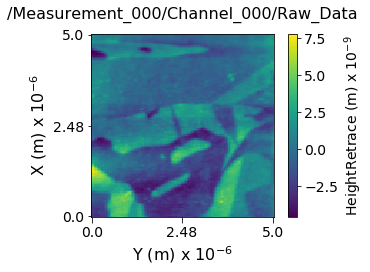

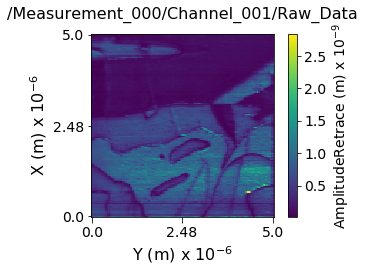

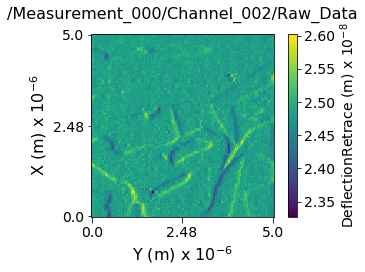

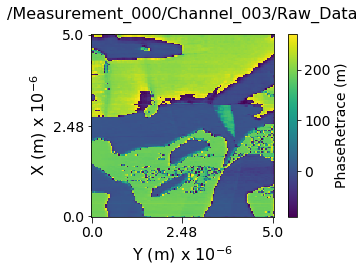

In [114]:
usid.plot_utils.use_nice_plot_params()
for main_dset in usid.hdf_utils.get_all_main(h5_file):
    main_dset.visualize(num_ticks=3)

In [1]:
%matplotlib inline

# NumpyTranslator for translating from proprietary file formats

an example of extracting data out of proprietary raw data files and writing the information into a **Universal Spectroscopy and Imaging Data (USID)** HDF5 file (referred to as a **h5USID** file) using the
``pyUSID.NumpyTranslator``

## Introduction

* In most scientific disciplines, commercial instruments tend to write the data and metadata out into proprietary file impedes access to the data
* The overwhelming part of this data wrangling effort is in investigating how to extract the data and metadata into memory. Often, the data and parameters in these files are **not** straightforward to access. 

* Simpler data such as images or single spectra can easily be written into plain text files. Simple or complex / large / multidimensional data can certainly be stored as numpy data files. However, there are significant drawbacks to writing data into non-standardized structures or file formats. 
    * First, while the structure of the data and metadata may be intuitive for the original author of the data, that may not be the case for another researcher. 

The process of copying data from the original format to **h5USID** files is called
**Translation** and the classes available in pyUSID and children packages such as pycroscopy that perform these
operation are called **Translators**.

Translation can be broken down into two basic components:

1. Extracting data and metadata out of the proprietary file format
2. Writing the extracted data and metadata into standardized h5USID files

## Import all necessary packages

In [2]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
import zipfile

# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Finally import pyUSID:
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

Procure the Raw Data file
=========================
Here we will download a compressed data file from Github and unpack it:



In [3]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/STS.zip'
zip_path = 'STS.zip'
if os.path.exists(zip_path):
    os.remove(zip_path)
_ = wget.download(url, zip_path, bar=None)

zip_path = os.path.abspath(zip_path)
# figure out the folder to unzip the zip file to
folder_path, _ = os.path.split(zip_path)
zip_ref = zipfile.ZipFile(zip_path, 'r')
# unzip the file
zip_ref.extractall(folder_path)
zip_ref.close()
# delete the zip file
os.remove(zip_path)

data_file_path = 'STS.asc'

### 1. Extracting data and metadata from proprietary files

#### 1.1 Explore the raw data file

Inherently, one may not know how to read these ``.asc`` files. One option is to try and read the file as a text file
one line at a time.

If one is lucky, as in the case of these ``.asc`` files, the file can be read like conventional text files.

Here is how we tested to see if the ``asc`` files could be interpreted as text files. Below, we read just the first 10 lines in the file

In [4]:
with open(data_file_path, 'r') as file_handle:
    for lin_ind in range(10):
        print(file_handle.readline().replace('\n', ''))

# File Format = ASCII
# Created by SPIP 4.6.5.0 2016-09-22 13:32
# Original file: C:\Users\Administrator\AppData\Roaming\Omicron NanoTechnology\MATRIX\default\Results\16-Sep-2016\I(V) TraceUp Tue Sep 20 09.17.08 2016 [14-1]  STM_Spectroscopy STM
# x-pixels = 100
# y-pixels = 100
# x-length = 29.7595
# y-length = 29.7595
# x-offset = -967.807
# y-offset = -781.441
# z-points = 500


#### 1.2 Read the contents of the file

* We can manually go through the file to find out which lines are important, at what lines the data starts etc.
    * Manual investigation of such ``.asc`` files revealed that these files are always formatted in the same way. Also, they contain instrument- and experiment-related parameters in the first ``403`` lines and then contain data which is arranged as one pixel per row.

    * STS experiments result in 3 dimensional datasets ``(X, Y, current)``. In other words, a 1D array of current data (as a function of excitation bias) is sampled at every location on a two dimensional grid of points. By knowing where the parameters are located and how the data is structured, it is possible to extract the necessary information from these files.

In [5]:
# Reading the entire file into memory
with open(data_file_path, 'r') as file_handle:
    string_lines = file_handle.readlines()

#### 1.3 Extract the metadata

In the case of these ``.asc`` files, the parameters are present in the first few lines of the file. 
 * we will demonstrate how we parse the first 17 lines to extract some very important parameters. Note that there are several other important parameters in the next 350 or so lines.
* First few lines of the file. If interested it is recommended to read the ``ASCTranslator`` available in ``pycroscopy`` for more complete details.

In [6]:
# Preparing an empty dictionary to store the metadata / parameters as key-value pairs
parm_dict = dict()

# Reading parameters stored in the first few rows of the file
for line in string_lines[3:17]:
    # Remove the hash / pound symbol, if any
    line = line.replace('# ', '')
    # Remove new-line escape-character, if any
    line = line.replace('\n', '')
    # Break the line into two parts - the parameter name and the corresponding value
    temp = line.split('=')
    # Remove spaces in the value. Remember, the value is still a string and not a number
    test = temp[1].strip()
    # Now, attempt to convert the value to a number (floating point):
    try:
        test = float(test)
        # In certain cases, the number is actually an integer, check and convert if it is:
        if test % 1 == 0:
            test = int(test)
    except ValueError:
        pass
    parm_dict[temp[0].strip()] = test

# Print out the parameters extracted
for key in parm_dict.keys():
    print(key, ':\t', parm_dict[key])

x-pixels :	 100
y-pixels :	 100
x-length :	 29.7595
y-length :	 29.7595
x-offset :	 -967.807
y-offset :	 -781.441
z-points :	 500
z-section :	 491
z-unit :	 nV
z-range :	 2000000000
z-offset :	 1116.49
value-unit :	 nA
scanspeed :	 59519000000
voidpixels :	 0


We recommend reformatting the parameter names to standardized nomenclature.
* We realize that the materials imaging community has not yet agreed upon standardized nomenclature for metadata.

* In pycroscopy, we may categorize the number of rows and columns in an image under ``grid`` and data sampling parameters under ``IO``.
    * As an example, we may rename ``x-pixels`` to ``positions_num_cols`` and ``y-pixels`` to ``positions_num_rows``.

#### 1.4 Extract parameters that define dimensions

Just having the metadata above and the main measurement data is insufficient to fully describe experimental data.
* We need to know how the experimental parameters were varied to acquire the multidimensional dataset.
    * how the grid of locations was defined and how the bias was varied to acquire the current information at each location. 

Since, we did not parse the entire list of parameters present in the file above, we will need to make some up.
Please refer to the formal ``ASCTranslator`` to see how this step would have been different.

In [7]:
num_rows = int(parm_dict['y-pixels'])
num_cols = int(parm_dict['x-pixels'])
num_pos = num_rows * num_cols
spectra_length = int(parm_dict['z-points'])

# We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
y_qty = 'Y'
y_units = 'nm'
y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

# We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
x_qty = 'X'
x_units = 'nm'
x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

# The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
bias_qty = 'Bias'
bias_units = 'V'
bias_vec = np.linspace(-1, 1, spectra_length)

#### 1.5 Extract the data

We have observed that the data in these ``.asc`` files are consistently present after the first ``403`` lines of
parameters. 
   * Using this knowledge, we need to populate a data array using data that is currently present as text lines in memory (from step 2).

* These ``.asc`` file store the 3D data (X, Y, spectra) as a 2D matrix (positions, spectra).
* Reading the 2D matrix from top to bottom, the data arranged column-by-column, and then row-by-row So, for simplicity, we will prepare an empty 2D numpy array to store the data as it exists in the raw data file.

Recall that in step 2, we were lucky enough to read the entire data file into memory given its small size.
The data is already present in memory as a list of strings that need to be parsed as a matrix of numbers.

In [8]:
num_headers = 403

raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

# Iterate over ever measurement position:
for pos_index in range(num_pos):
    # First, get the correct (string) line corresponding to the current measurement position.
    # Recall that we would need to skip the many header lines to get to the data
    this_line = string_lines[num_headers + pos_index]
    # Each (string) line contains numbers separated by tabs (``\t``). Let us break the line into several shorter strings
    # each containing one number. We will ignore the last entry since it is empty.
    string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
    # Now that we have a list of numbers represented as strings, we need to convert this list to a 1D numpy array
    # the converted array is set to the appropriate position in the main 2D array.
    raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)

If the data is so large that it cannot fit into memory, we would need to read data one (or a few) position(s) at a
time, process it (e.g. convert from string to numbers), and write it to the HDF5 file without keeping much or any data
in memory.

The three-dimensional dataset (``Y``, ``X``, ``Bias``) is currently represented as a two-dimensional array:
(``X`` * ``Y``, ``Bias``). To make it easier for us to understand and visualize, we can turn it into a 3D array:



In [9]:
raw_data_3d = raw_data_2d.reshape(num_rows, num_cols, spectra_length)
print('Shape of 2D data: {}, Shape of 3D data: {}'.format(raw_data_2d.shape, raw_data_3d.shape))

Shape of 2D data: (10000, 500), Shape of 3D data: (100, 100, 500)


Just as we did for the parameters (``X``, ``Y``, and ``Bias``) that were varied in the experiment,
we need to specify the quantity that is recorded from the sensors / detectors, units, and what the data
represents:



In [10]:
main_data_name = 'STS'
main_qty = 'Current'
main_units = 'nA'

## Visualize the extracted data

Here is a visualization of the current-voltage spectra at a few locations:



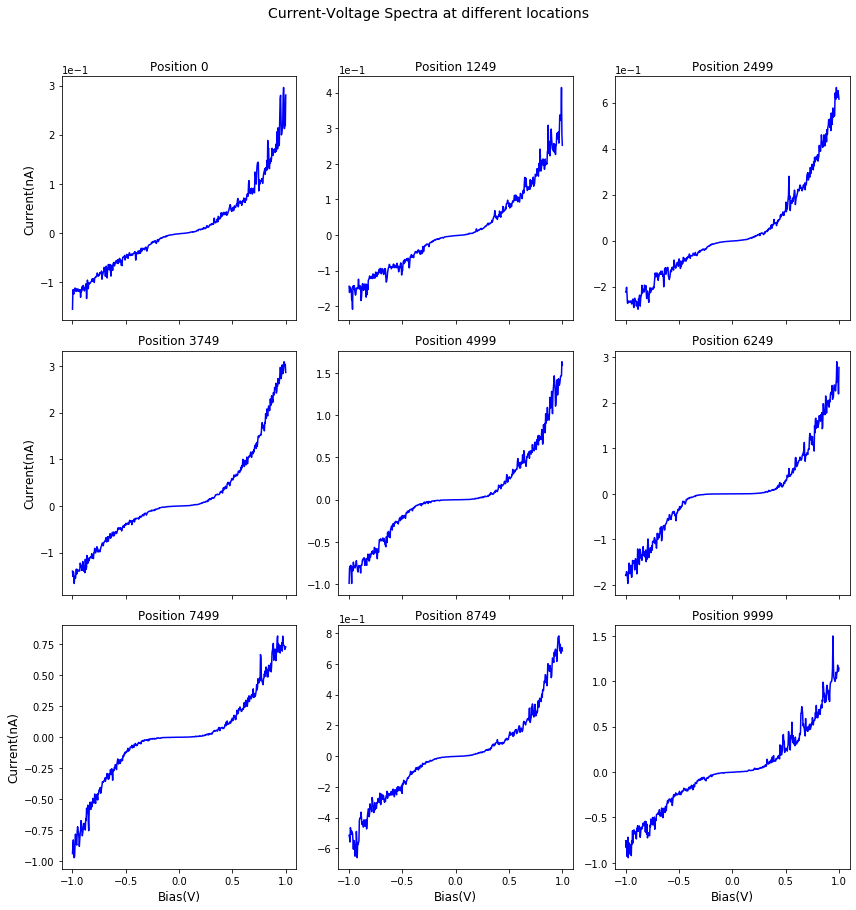

In [11]:
fig, axes = usid.plot_utils.plot_curves(bias_vec, raw_data_2d, num_plots=9,
                                        x_label=bias_qty + '(' + bias_units + ')',
                                        y_label=main_qty + '(' + main_units + ')',
                                        title='Current-Voltage Spectra at different locations',
                                        fig_title_yoffset=1.05)

Here is a visualization of spatial maps at different bias values



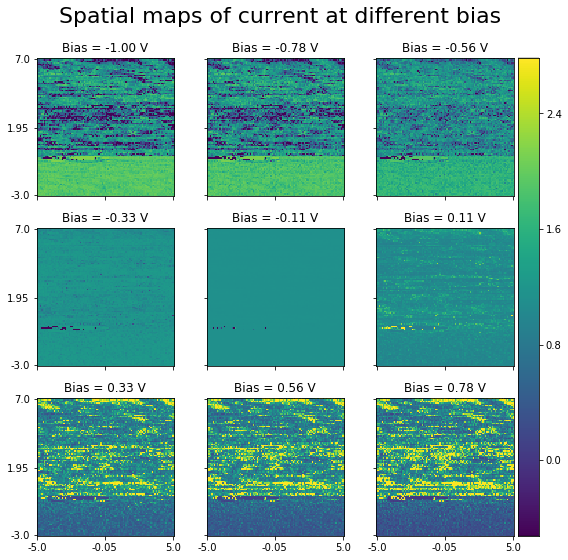

In [12]:
fig, axes = usid.plot_utils.plot_map_stack(raw_data_3d, reverse_dims=True, pad_mult=(0.15, 0.15),
                                           title='Spatial maps of current at different bias', stdevs=2,
                                           color_bar_mode='single', num_ticks=3, x_vec=x_vec, y_vec=y_vec,
                                           evenly_spaced=True, fig_mult=(3, 3), title_yoffset=0.95)

for axis, bias_ind in zip(axes, np.linspace(0, len(bias_vec), 9, endpoint=False, dtype=np.uint)):
    axis.set_title('Bias = %3.2f V' % bias_vec[bias_ind])

# Writing information into h5USID files

We have captured all the information from the ``.asc`` files. We are now ready to write the data into USID
formatted HDF5 files! We will be using the ``pyUSID.NumpyTranslator`` class for this stage.

The ``NumpyTranslator`` class can be used in two different ways. We will go over both methods.

## A NumpyTranslator as a quick file writer

Though not intended to be used in this manner, the ``NumpyTranslator`` can be used in scripts to quickly write out
data into a HDF5 file. 
* The benefit over simply saving data using `numpy.save() <https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html>`_ is that the data will be written in a way that it will be accessible by the `pyUSID.USIDataset <./plot_usi_dataset.html>`_ 
* class that offers several handy capabilities. 

### 2.A.1 Preparing the name of the new HDF5 file

Below, we will specify the name of the HDF5 file that we want to write the prepared data and metadata. This step
would need to be performed regardless of whether one is writing data out into numpy files, text files, spreadsheets,
or h5USID files (this case).

In [13]:
# First, let us separate the file name from the path to the folder containing the raw data file
folder_path, file_name = os.path.split(data_file_path)
# Next, we will remove the ``.asc`` extension
file_name = file_name[:-4] + '_Script'
# The new file name will share the same base name as the original file but will end with a ``.h5`` extension.
# This HDF5 or H5 file will live in the same folder as the raw data file
h5_path_1 = os.path.join(folder_path, file_name + '.h5')

### 2.A.2 Preparing `Dimension` objects

Before the ``NumpyTranslator`` can be used, we need to formally define the dimensions that define the
three-dimensional measurement in the data file. 
* In this example, we have two `Position` dimensions - ``X`` and ``Y`` and one `Spectroscopic` dimension - ``Bias`` against which data for each spectra were collected.

In pyUSID, we formally define dimensions using simple `pyUSID.Dimension <../intermediate/plot_write_utils.html#dimension>`_ objects. These ``Dimension`` objects are simply
descriptors of dimensions and take the name of the quantity, physical units, and the values over which the dimension
was varied. 
* Both, the `Position` and `Spectroscopic` dimensions need to be defined using ``Dimension`` objects and the ``Dimension`` objects should be arranged from fastest varying to slowest varying dimensions.

    * The `Spectroscopic` dimensions are trivial since we only have one dimension - ``Bias``.

In [14]:
spec_dims = usid.Dimension(bias_qty, bias_units, bias_vec)

In [16]:
type(spec_dims)

pyUSID.io.write_utils.Dimension

Given that the spectra were acquired column-by-column and then row-by-row, we would need to arrange the `Position`
dimensions as ``X`` followed by ``Y``.



In [17]:
pos_dims = [usid.Dimension(x_qty, x_units, x_vec),
            usid.Dimension(y_qty, y_units, y_vec)]

### 2.A.3 Reshape the Main data (if necessary)

Recall that ``Main`` datasets in USID are two dimensional in shape where all position dimensions (``X``, and ``Y`` in
this case) are collapsed along the first axis and the spectroscopic dimensions (``Bias`` in this case) are
collapsed along the second axis.

Fortunately, this is exactly how the data was already laid out in the original raw data file. So, we can use that two-dimensional array as is. We can skip this step.

#### 2.A.4 Writing to a h5USID file

We are now ready to use the ``NumpyTranslator!``
The NumpyTranslator simplifies the creation of h5USID files. It handles the HDF5 file creation,
HDF5 dataset creation and writing, creation of ancillary HDF5 datasets, group creation, writing parameters, linking
ancillary datasets to the main dataset etc. With a single call to the ``translate()`` function of the
``NumpyTranslator``, we complete the translation process:

In [18]:
tran = usid.NumpyTranslator()
_ = tran.translate(h5_path_1, main_data_name,
                   raw_data_2d, main_qty, main_units,
                   pos_dims, spec_dims,
                   parm_dict=parm_dict)

# Verifying the newly written H5 file:

Let us perform some simple and quick verification to show that the data has indeed been translated correctly:



Contents of the h5USID file:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Comprehensive information about the Main dataset:
-------------------------------------------------
<HDF5 dataset "Raw_Data": shape (10000, 500), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 100 
	Y - size: 100 
Spectroscopic Dimensions: 
	Bias - size: 500
Data Type:
	float32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Verification plots:


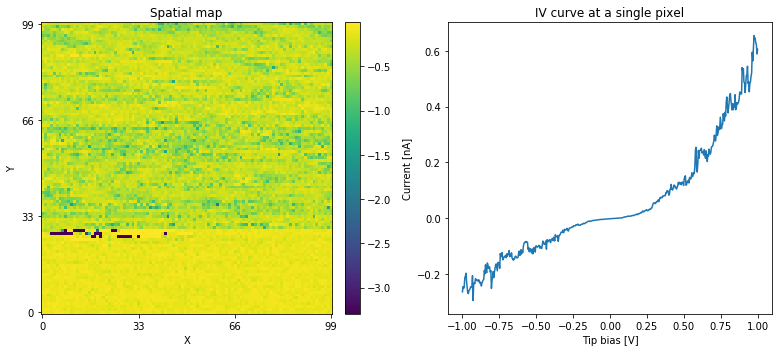

In [19]:
with h5py.File(h5_path_1, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    print('Contents of the h5USID file:')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    usid.hdf_utils.print_tree(h5_file)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Comprehensive information about the Main dataset:')
    print('-------------------------------------------------')
    h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
    print(h5_main)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Verification plots:')
    fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    usid.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]),
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

    fig.tight_layout()

## 2.B Extending the NumpyTranslator

What we have done above is essentially, write real measurement data and metadata into a standardized USID HDF5 file.
* The process of writing to the HDF5 file is rather simple because of the ``NumpyTranslator``.
    * The above code is part of a script that is susceptible to errors. Minor changes in the naming / formatting of certain strings, reshaping of the datasets can very quickly break analysis or visualization code later on.
* Encapsulating the data reading and writing process into a formal ``Translator`` class also makes it easier for others to use it and write data into the same consistent format. 
    * In fact, upon writing the class, proprietary data files can be translated using just two lines as we will see below.

Therefore, we recommend extending the ``NumpyTranslator`` class, when possible, instead of using it independently
like a function.

### Defining the class

Writing a python class that extends the ``NumpyTranslator`` class is far less intimidating than it sounds. The code
that goes into the class is virtually identical to what has been written above. 

In [20]:
class ExampleTranslator(usid.NumpyTranslator):
    """
    The above definition of the class states that our ExampleTranslator inherits all the capabilities and
    behaviors of the NumpyTranslator class and builds on top of it
    """

    def translate(self, input_file_path):
        """
        Extracts the data and metadata out of proprietary formatted files and writes it into a SID formatted HDF5 file

        Parameters
        ----------
        input_file_path : str
            Path to the input data file containing all the information

        Returns
        -------
        h5_path_out_2 : str
            Path to the USID HDF5 output file
        """

        """
        --------------------------------------------------------------------------------------------
        1. Extracting data and metadata out of the proprietary file
        --------------------------------------------------------------------------------------------
        1.2 Read the contents of the file into memory
        """
        with open(input_file_path, 'r') as file_handle:
            string_lines = file_handle.readlines()

        """
        1.3 Extract all experiment and instrument related parameters
        """
        parm_dict = dict()

        for line in string_lines[3:17]:
            line = line.replace('# ', '')
            line = line.replace('\n', '')
            temp = line.split('=')
            test = temp[1].strip()
            try:
                test = float(test)
                if test % 1 == 0:
                    test = int(test)
            except ValueError:
                pass
            parm_dict[temp[0].strip()] = test

        """
        1.4 Extract or generate parameters that define the three dimensions
        """

        num_rows = int(parm_dict['y-pixels'])
        num_cols = int(parm_dict['x-pixels'])
        num_pos = num_rows * num_cols
        spectra_length = int(parm_dict['z-points'])

        # We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
        y_qty = 'Y'
        y_units = 'nm'
        y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

        # We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
        x_qty = 'X'
        x_units = 'nm'
        x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

        # The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
        bias_qty = 'Bias'
        bias_units = 'V'
        bias_vec = np.linspace(-1, 1, spectra_length)

        """
        1.5 Extract the data
        """
        num_headers = 403

        raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

        # Iterate over ever measurement position:
        for pos_index in range(num_pos):
            this_line = string_lines[num_headers + pos_index]
            string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
            raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)

        """
        2.1 Prepare the output file path
        """
        folder_path, file_name = os.path.split(data_file_path)
        h5_path = os.path.join(folder_path, file_name[:-4] + '_Class' + '.h5')

        """
        --------------------------------------------------------------------------------------------
        2.B Writing to h5USID file using pyUSID
        --------------------------------------------------------------------------------------------
        2.B.2 Expressing the Position and Spectroscopic Dimensions using pyUSID.Dimension objects
        """
        pos_dims = [usid.Dimension(x_qty, x_units, x_vec),
                    usid.Dimension(y_qty, y_units, y_vec)]
        spec_dims = usid.Dimension(bias_qty, bias_units, bias_vec)

        """
        2.B.3 Reshape the Main data from its original N-dimensional form to the USID 2D form 
            We skip this step since it is unnecessary in this case
            
        2.B.4 Call the translate() function of the base NumpyTranslator class   
        """
        _ = super(ExampleTranslator, self).translate(h5_path, main_data_name,
                                                     raw_data_2d, main_qty, main_units,
                                                     pos_dims, spec_dims,
                                                     parm_dict=parm_dict)

        return h5_path

### Comments

The vast majority of the code in the Class (and the script above it) pertain to the
first phase - the extraction of data and metadata out of the proprietary file format. 
* The parts specific to writing the data to the h5USID file are no more than 4-5 lines.

The code in this class is virtually identical to the code above. Perhaps the biggest differences between the two codes come in the definition of the class and section ``2.B.4``:

In section ``2.A.4`` above, we had instantiated the ``NumpyTranslator`` and called its ``translate()`` method:

```python

    tran = usid.NumpyTranslator()
    h5_path_out_1 = tran.translate(...)
```

In the case of the ``ExampleTranslator`` class above, we define the class itself as an extension / child class of the
``NumpyTranslator`` in this line:

```python

    class ExampleTranslator(usid.NumpyTranslator):
```

This means that our ``ExampleTranslator`` class inherits all the capabilities (including our favorite -
``translate()`` function) and behaviors of the ``NumpyTranslator`` class and builds on top of it. This is why we don't
need to instantiate the ``NumpyTranslator`` in section ``2.B.4``. All we are doing in our ``translate()`` function is
adding the intelligence that is relevant to our specific scientific example and piggybacking on the many capabilities
of the ``NumpyTranslator`` class for the actual file writing. This piggybacking is visible in the last line:

```python

    h5_path_out_1 = super(ExampleTranslator, self).translate(....)
```
Essentially, we are asking ``NumpyTranslator.translate()`` to take over and do the rest.

Using this ExampleTranslator
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
What we did above is provide a template for what should happen when someone provides an input file. We have not really
tried it out yet. The lines below will illustrate how easy it becomes to perform `translations` from now on:

In [21]:
# instantiate the class first:
my_tran = ExampleTranslator()
# Then call the translate function:
h5_path_2 = my_tran.translate(data_file_path)

Once the class is written, translations become a two-line operation!

## Verifying the newly written H5 file:
====================================
Let us perform some simple and quick verification to show that the data has indeed been translated correctly:



Contents of the h5USID file:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Comprehensive information about the Main dataset:
-------------------------------------------------
<HDF5 dataset "Raw_Data": shape (10000, 500), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 100 
	Y - size: 100 
Spectroscopic Dimensions: 
	Bias - size: 500
Data Type:
	float32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Verification plots:


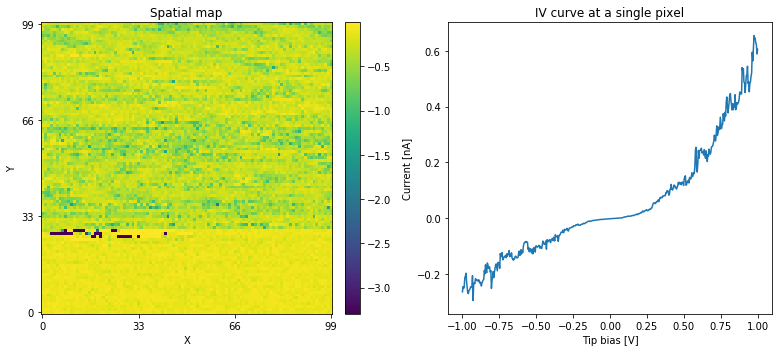

In [22]:
with h5py.File(h5_path_2, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    print('Contents of the h5USID file:')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    usid.hdf_utils.print_tree(h5_file)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Comprehensive information about the Main dataset:')
    print('-------------------------------------------------')
    h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
    print(h5_main)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Verification plots:')
    fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
    spat_map = np.reshape(h5_main[:, 100], (100, 100))
    usid.plot_utils.plot_map(axes[0], spat_map, origin='lower')
    axes[0].set_title('Spatial map')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[1].plot(np.linspace(-1.0, 1.0, h5_main.shape[1]),
                 h5_main[250])
    axes[1].set_title('IV curve at a single pixel')
    axes[1].set_xlabel('Tip bias [V]')
    axes[1].set_ylabel('Current [nA]')

    fig.tight_layout()

## Limits of the NumpyTranslator

The ``NumpyTranslator`` is perfect when one is dealing with a **single** USID `Main` dataset. However, if the
proprietary file contained multiple such 3D hyperspectral images, one would need to use the lower-level functions that
power the ``NumpyTranslator``. pyUSID offers
`several functions <./intermediate/plot_hdf_utils_write.html#write-main-dataset>`_ that make it easy to handle such
more involved translations.

## What about the base Translator class?

The ``pyUSID.Translator`` class is a highly abstract class and does not do much. The ``Translator`` class exists only
to standardize the way in which translators are operated - the instantiation of the class followed by the call to the
``translate()`` method. The ``NumpyTranslator`` is itself
a child class of the ``Translator`` class and is the lowest class capable of doing something by itself while still
being application-agnostic.

## More information

Our sister class - pycroscopy, has several
`translators <https://github.com/pycroscopy/pycroscopy/tree/master/pycroscopy/io/translators>`_ that translate popular
file formats generated by nanoscale imaging instruments. Some of the translators extend the ``NumpyTranslator`` like
we did above, while others use the low-level functions in ``pyUSID.hdf_utils``.

A single, robust Translator class can handle the finer variations / modes in the data. See the
`IgorIBWTranslator <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/igor_ibw.py>`_
as an example.

We have found python packages online to open a few proprietary file formats and have written translators using these
packages. If you are having trouble reading the data in your files and cannot find any packages online, consider
contacting the manufacturer of the instrument which generated the data in the proprietary format for help.

Cleaning up
===========
Remove both the original and translated files:

In [23]:
os.remove(h5_path_1)
os.remove(h5_path_2)
os.remove(data_file_path)